In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import theano
import theano.tensor as T
import numpy as np
import matplotlib.pyplot as plt

import copy
import pickle

Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce GTX 1050 (0000:01:00.0)


In [2]:
#import hmm_main as h

In [2]:
from sklearn.metrics import classification_report
from scipy.special import softmax
from os import walk
import random

In [3]:
class HMM:
    def __init__(self, M, K):
        self.M = M  # number of hidden states
        self.K = K  # number of Gaussians

    def fit(self, X, learning_rate=1e-2, max_iter=10, keep=False):
        # train the HMM model using the Baum-Welch algorithm
        # a specific instance of the expectation-maximization algorithm

        N = len(X)
        D = X[0].shape[1]  # assume each x is organized (T, D)

        if not keep:
            pi0 = np.ones(self.M)  # initial state distribution
            A0 = np.random.randn(self.M, self.M)  # state transition matrix
            R0 = np.ones((self.M, self.K))  # mixture proportions
            mu0 = np.zeros((self.M, self.K, D))
            for i in range(self.M):
                for k in range(self.K):
                    random_idx = np.random.choice(N)
                    x = X[random_idx]
                    random_time_idx = np.random.choice(len(x))
                    mu0[i, k] = x[random_time_idx]
            sigma0 = np.zeros((self.M, self.K, D, D))
            for j in range(self.M):
                for k in range(self.K):
                    sigma0[j,k] = np.eye(D)
            thx, cost = self.set(pi0, A0, R0, mu0, sigma0)
        else:
            thx, cost = self.set(self.preSoftmaxPi.get_value(), self.preSoftmaxA.get_value(),
                                 self.preSoftmaxR.get_value(), self.mu.get_value(), self.sigma.get_value())

        pi_update = self.preSoftmaxPi - learning_rate * T.grad(cost, self.preSoftmaxPi)
        A_update = self.preSoftmaxA - learning_rate * T.grad(cost, self.preSoftmaxA)
        R_update = self.preSoftmaxR - learning_rate * T.grad(cost, self.preSoftmaxR)
        mu_update = self.mu - learning_rate * T.grad(cost, self.mu)
        sigma_update = self.sigma - learning_rate * T.grad(cost, self.sigma)

        updates = [
            (self.preSoftmaxPi, pi_update),
            (self.preSoftmaxA, A_update),
            (self.preSoftmaxR, R_update),
            (self.mu, mu_update),
            (self.sigma, sigma_update),
        ]

        train_op = theano.function(
            inputs=[thx],
            updates=updates,
        )

        costs = []
        for it in range(max_iter):
            print("it:", it)
            c = self.log_likelihood_multi(X).sum()
            print("c:", c)
            costs.append(c)
           
            for n in range(N):
                      
                train_op(X[n])

        return costs

    def set(self, preSoftmaxPi, preSoftmaxA, preSoftmaxR, mu, sigma):
        self.preSoftmaxPi = theano.shared(preSoftmaxPi)
        self.preSoftmaxA = theano.shared(preSoftmaxA)
        self.preSoftmaxR = theano.shared(preSoftmaxR)
        self.mu = theano.shared(mu)
        self.sigma = theano.shared(sigma)
        M, K = preSoftmaxR.shape
        self.M = M
        self.K = K

        pi = T.nnet.softmax(self.preSoftmaxPi).flatten()
        A = T.nnet.softmax(self.preSoftmaxA)
        R = T.nnet.softmax(self.preSoftmaxR)

        D = self.mu.shape[2]
        twopiD = (2 * np.pi) ** D

        # set up theano variables and functions
        thx = T.matrix('X')  # represents a TxD matrix of sequential observations

        def mvn_pdf(x, m, S):
            k = 1 / T.sqrt(twopiD * T.nlinalg.det(S))
            e = T.exp(-0.5 * (x - m).T.dot(T.nlinalg.matrix_inverse(S).dot(x - m)))
            return k * e

        def gmm_pdf(x):
            def state_pdfs(xt):
                def component_pdf(j, xt):
                    Bj_t = 0
                    # j = T.cast(j, 'int32')
                    for k in range(self.K):
                        # k = int(k)
                        # a = R[j,k]
                        # b = mu[j,k]
                        # c = sigma[j,k]
                        #L = self.sigma[j, k]
                        S = self.sigma[j][k]#L.dot(L.T)
                        Bj_t += R[j, k] * mvn_pdf(xt, self.mu[j, k], S)
                    return Bj_t

                Bt, _ = theano.scan(
                    fn=component_pdf,
                    sequences=T.arange(self.M),
                    n_steps=self.M,
                    outputs_info=None,
                    non_sequences=[xt],
                )
                return Bt

            B, _ = theano.scan(
                fn=state_pdfs,
                sequences=x,
                n_steps=x.shape[0],
                outputs_info=None,
            )
            return B.T

        B = gmm_pdf(thx)

        # scale = T.zeros((thx.shape[0], 1), dtype=theano.config.floatX)
        # scale[0] = (self.pi*B[:,0]).sum()

        def recurrence(t, old_a, B):
            a = old_a.dot(A) * B[:, t]
            s = a.sum()
            return (a / s), s

        [alpha, scale], _ = theano.scan(
            fn=recurrence,
            sequences=T.arange(1, thx.shape[0]),
            outputs_info=[pi * B[:, 0], None],
            n_steps=thx.shape[0] - 1,
            non_sequences=[B],
        )

        cost = -T.log(scale).sum()
        self.cost_op = theano.function(
            inputs=[thx],
            outputs=cost,
        )

        cost_detect = -T.log(scale)
        self.cost_detect = theano.function(
            inputs=[thx],
            outputs=cost_detect,
        )
        return thx, cost

    def log_likelihood_multi(self, X):
        return np.array([self.cost_op(x) for x in X])

    def log_likelihood_detect(self, X):
        return np.array(self.cost_detect(X))

In [4]:
dataset = pd.read_csv('D:/magistracy/Industry/GHL/train_1500000_seed_11_vars_23.csv', 
                      index_col=['Time'], parse_dates=['Time'])

In [5]:
y1 = dataset['inj_valve_act'].copy().values.tolist( )
y2 = list(map(lambda x: x*2, dataset['out_valve_act'].copy().values.tolist( )))
y3 = list(map(lambda x: x*3, dataset['inv_valve_act'].copy().values.tolist( )))
y4 = list(map(lambda x: x*4, dataset['Relaxing.active'].copy().values.tolist( )))
y5 = list(map(lambda x: x*5, dataset['heater_act'].copy().values.tolist( ))) 
y6 = list(map(lambda x: x*5, dataset['dir_valve_act'].copy().values.tolist( )))
dataset['state'] = list(map(lambda x1,x2,x3,x4,x5,x6:(int(x1+x2+x3+x4+x5+x6)), y1, y2, y3, y4, y5, y6))

In [36]:
df_heater_act = dataset.query("state == 5")

In [37]:
dataset.head()

,RT_level_ini,RT_temperature.T,HT_temperature.T,RT_level,out_valve_act,dT_rand,inv_valve_act,limiter.y,inj_valve_act,Relaxing.active,boundary.m_flow_in,dir_valve_act,dt_rand,C_level,C_temperature.T,heater_act,HT_level,limiter1.y,dL_rand,state
Time,,,,,,,,,,,,,,,,,,,,
0.0,0.0,283.149994,283.149994,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0,0
1.0,0.0,283.149994,283.163330,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0,0
2.0,0.0,283.149994,283.176666,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0,0
3.0,0.0,283.149994,283.189972,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0,0
4.0,0.0,283.149994,283.203247,0.5,0.0,0.0,0.0,283.0,0.0,0.0,0.0,0.0,0.0,0.01,273.149994,0.0,0.1,100.0,0.0,0


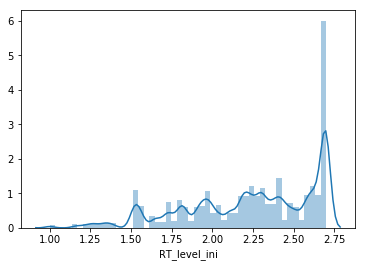

In [167]:
sns.distplot(df_heater_act['RT_level_ini']);

In [38]:
df1 = dataset
df1 = df1.reset_index(drop = True)
df1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 20 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   RT_level_ini        1048575 non-null  float64
 1   RT_temperature.T    1048575 non-null  float64
 2   HT_temperature.T    1048575 non-null  float64
 3   RT_level            1048575 non-null  float64
 4   out_valve_act       1048575 non-null  float64
 5   dT_rand             1048575 non-null  float64
 6   inv_valve_act       1048575 non-null  float64
 7   limiter.y           1048575 non-null  float64
 8   inj_valve_act       1048575 non-null  float64
 9   Relaxing.active     1048575 non-null  float64
 10  boundary.m_flow_in  1048575 non-null  float64
 11  dir_valve_act       1048575 non-null  float64
 12  dt_rand             1048575 non-null  float64
 13  C_level             1048575 non-null  float64
 14  C_temperature.T     1048575 non-null  float64
 15  heater_act     

In [39]:
def get_id_start_end(df):
    df_0 = df.query("state == 0")
    index = df_0.index.tolist()
    #получаем список начальных и конечных индексов
    index_start = [0]+ [index[i+2] for i in range(0, len(index)-2) if index[i+1]-index[i] > 1]
    index_end =  [index[i+1] for i in range(0, len(index)-1) if index[i+1]-index[i] > 1]+[dataset.index.max()]
    return index_start, index_end

#максимальная длина производственного цикла = 9534
def get_sampels(df, l = 13981, col = ['RT_level']):
    #id_start, id_end = get_id_start_end(df)
    X = []
    for j in range(0,len(df)-l+1,l):
        ar = np.zeros((l,len(col)))
        for i in range(len(col)):
            ar[:,i] = df[col[i]][j:j+l].copy().values
        X.append(ar)
    return X

def get_sampels_new(df, ws = 100, seq_len=1000, col = ['RT_level']):
    ar= df1[col].copy().values
    #print(ar.shape)
    ar = np.array_split(ar, len(df1)//10, axis=0)
    ar = [np.sum(x,axis=0)/x.shape[0] for x in ar]
    X = np.array_split(np.array(ar), len(ar)//seq_len, axis=0)
    
    return X


In [40]:
ws = 10
l = 5000
col =['RT_level', 'HT_temperature.T']
X = get_sampels_new(df1, ws, l, col)
random.shuffle(X)

In [41]:
len(X)

20

In [42]:
X_train = X[:17]
X_val_test = X[17:]

In [173]:
X_val_test[0].shape

(5243, 2)

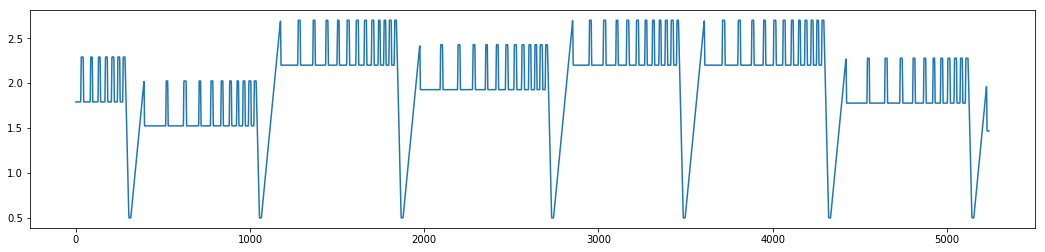

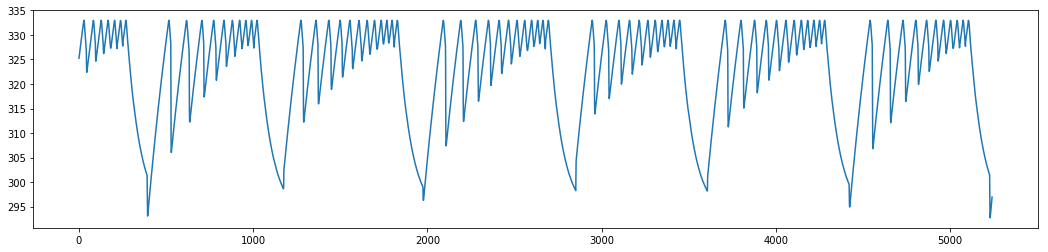

In [174]:
n=0
fig = plt.figure(figsize=(18, 4))
plt.plot( X_train[n][:,0])
plt.show()

fig = plt.figure(figsize=(18, 4))
plt.plot(X_train[n][:,1])
plt.show()

#fig = plt.figure(figsize=(18, 4))
#plt.plot(X_train[n][:,2])
#plt.show()


In [15]:
def get_batch(X, batch_size):
    idx = np.random.randint(0, len(X), batch_size)
    return [X[i] for i in idx]

def train(model, X_train, X_test, keep = False, num_epoch = 10, batch_size = 15, learning_rate=10e-3, max_iter=10, early_stopping_patience = 2):
    best_model = copy.deepcopy(model)
    best_val_loss = float('inf')
    best_epoch_i = 0
    histoty_costs_train = []
    #keep = False
    for epoch_i in range(num_epoch):
        print('Epoch: {}'.format(epoch_i))
        
        batch = get_batch(X_train, batch_size)
        #print('batch.shape', len(batch), batch[0].shape)
        costs = model.fit(batch, learning_rate, max_iter, keep)
        keep = True
        histoty_costs_train.append(costs)
        
        LL_train = model.log_likelihood_multi(batch).sum()/batch_size
        
        #batch_test = get_batch(X_test, batch_size)
        LL_test = model.log_likelihood_multi(X_test).sum()/len(X_test)
        print('LL for train:', LL_train, 'LL for test:', LL_test)
        
        if LL_train < best_val_loss:
            best_epoch_i = epoch_i
            best_val_loss = LL_train
            best_model = copy.deepcopy(model)
            print('Новая лучшая модель!')
            with open('C:/Users/DNS/NIR/hmm_gasoil.pkl', 'wb') as dump_out:
                pickle.dump(model, dump_out)
        elif epoch_i - best_epoch_i > early_stopping_patience:
           print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format(early_stopping_patience))
           break
              
    return best_model, histoty_costs_train       
        


In [30]:
hmm_model = HMM(3,3)

In [ ]:
num_epoch = 5
batch_size = 10
learning_rate = 10e-6
max_iter = 10
early_stopping_patience = 2
keep= False

best_model, histoty_costs_train = train(hmm_model, X_train, X_val_test, keep, num_epoch, batch_size, learning_rate, max_iter, early_stopping_patience)

In [76]:
LL_train = hmm_model.log_likelihood_multi(X_train[:5]).sum()
LL_test = hmm_model.log_likelihood_multi(X_val_test[:5]).sum()
print(LL_train,LL_test)

223768.17233166285 214164.61239608983


In [37]:
L = hmm_model.sigma.get_value()[2][0]#[1]
mu = hmm_model.mu.get_value()[2][0]
x = np.random.multivariate_normal(mu, L)
x, mu


(array([  2.05451324, 326.6598589 ]), array([  1.84136398, 326.26377791]))

In [ ]:
hmm_model.sigma.get_value()

<function matplotlib.pyplot.show(*args, **kw)>

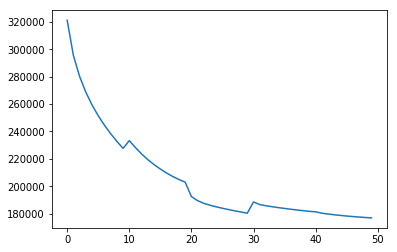

In [22]:
plt.plot(np.concatenate(histoty_costs_train))
plt.show


In [23]:
# ЗАПИСЬ!!!!!
with open('C:/Users/DNS/NIR/hmm_gasoil_base_3_3.pkl', 'wb') as dump_out:
      pickle.dump(hmm_model, dump_out)#pickle.dump(best_model, dump_out)

In [6]:
# ЧТЕНИЕ
with open('C:/Users/DNS/NIR/hmm_gasoil_base_3_3.pkl', 'rb') as dump_out:
      hmm = pickle.load(dump_out)


In [43]:
LL_train = hmm.log_likelihood_multi(X_train).sum()/len(X_train)
LL_test = hmm.log_likelihood_multi(X_val_test).sum()/len(X_val_test)
print(LL_train,LL_test)

17898.60629998674 17050.329296670647


ДЕТЕКТИРОВАНИЕ АНОМАЛИЙ!!!!!!

In [7]:
def hmm_init(model):
    
    mu = model.mu.get_value()
    sigma = model.sigma.get_value()
    
    pi = softmax(model.preSoftmaxPi.get_value())
    A = softmax(model.preSoftmaxA.get_value(), axis=1)
    R = softmax(model.preSoftmaxR.get_value(), axis=1)
    D = mu.shape[2]
    M, K = R.shape
    
    return M, K, D, pi, A, R, mu, sigma
    
def get_signals(N=20, T=100, init=hmm_init, hmm_model = None):
    if init == hmm_init:
        M, K, D, pi, A, R, mu, sigma = init(hmm_model)
        X = []
    
        def get_sigma_s_r(hmm_model, s, r, sigma):
            if hmm_model != None:
                L = sigma[s,r]
                return L.dot(L.T)
            else:
                return sigma[s,r]

        for n in range(N):
            x = np.zeros((T, D))
            s = np.random.choice(M, p = pi) # выбираем начальное состояние
            r = np.random.choice(K, p=R[s]) # choose mixture
            
            x[0] = np.random.multivariate_normal(mu[s][r], sigma[s][r])
            for t in range(1, T):
                s = np.random.choice(M, p=A[s]) # choose state
                r = np.random.choice(K, p=R[s]) # choose mixture
                x[t] = np.random.multivariate_normal(mu[s][r], sigma[s][r])
            X.append(x)
    return X
    

In [37]:
signals = np.array(get_signals(N=10, T=1000, init =hmm_init, hmm_model=hmm))
signal = np.sum(signals, axis=0)/10
hmm.log_likelihood_multi([signal])[0]

3558.533978795638

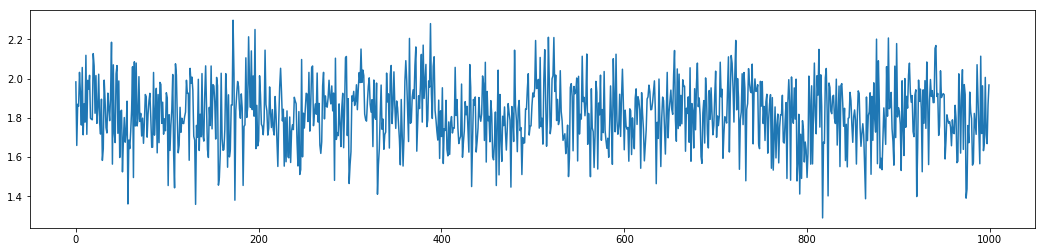

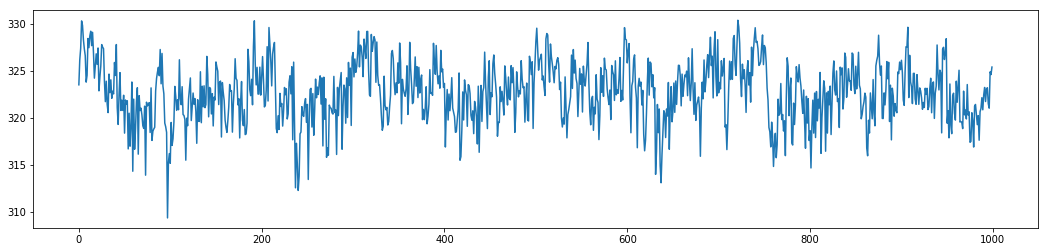

In [19]:
fig = plt.figure(figsize=(18, 4))
axis = range(signal.shape[0])
plt.plot(axis,signal[:,0])
plt.show()
fig = plt.figure(figsize=(18, 4))
plt.plot(axis, signal[:,1])
plt.show()
#fig = plt.figure(figsize=(18, 4))
#plt.plot(axis, signal[0][:,2])
#plt.show()



In [8]:
def anomaly_detection(LL_std, hmm_model, signal, win_size= 100, eps = 0.25, step = 1):
    n_step = signal.shape[0]
    LL = hmm_model.log_likelihood_detect(signal)#[0]
    an = np.zeros(n_step)
    Y = np.zeros(n_step)  
    for t in range(0,(n_step-win_size+step) , step):
        if t > (n_step-win_size):
            t = n_step-win_size
        #LL = hmm_model.log_likelihood_multi([signal[t:t+win_size]]).sum()    
        MAPE = abs(LL[t:t+win_size].sum()-LL_std)/LL_std
        #print(MAPE)
        if MAPE > eps :
            if t+win_size == n_step:
                Y[t:t+win_size] =1
            else:
                Y[t+win_size-step:t+win_size] =1
            #LL[t] = LL_hmm[t]
    #Y[np.where(an>an.max()*sens)] = 1          
    return Y 

def predict(model, X, win_size=50, eps=0.25, step =1):
    Y_pred = []
    hmm_signal = get_signals(10, win_size ,init=hmm_init, hmm_model = model)
    LL_std = model.log_likelihood_multi(hmm_signal).sum()/10
    for i in range(len(X)):
        #print(i)
        Y_pred.append(anomaly_detection(LL_std, model, X[i], win_size, eps, step))
        
    return Y_pred

def print_result(X, Y, Y_pred, N=3, dim=0):
    for n in range(N):
        norm = np.ma.masked_where(Y_pred[n]==0,X[n][:,dim])
        anom = np.ma.masked_where(Y_pred[n]==1,X[n][:,dim])
        fig = plt.figure(figsize=(18, 4))
        axis = range(Y_pred[n].shape[0])
        idxs = np.where(Y[n] == Y[n].max())[0]
        for i in idxs:
            plt.axvspan(i, i, color='yellow')
        if dim==1:
            plt.plot(axis, norm, axis, anom, axis, Y_pred[n]*60+290)
        else:
            plt.plot(axis, norm, axis, anom, axis, Y_pred[n]*3)
        plt.show()         
    
def get_test_data(name_files, path ='D:/magistracy/Industry/GHL/test/', col = ['RT_level','HT_temperature.T']):
    X = []
    Y = []
    for f in name_files:
        df = pd.read_csv(path+f, index_col=['Time'], parse_dates=['Time'])
        x = df[col].copy().values
        x = x[2000:]
        l = x.shape[0]//2
        x = x.reshape(2,l,x.shape[1])
       
        y = df['DANGER'].copy().values + df['FAULT'].copy().values
        y = y[2000:]
        idx = np.where(y>=1)
        y[idx] =1
        y = y.reshape(2,l)
        
        if np.where(y[0]==1)[0].shape[0] != 0:
            x = np.array_split(x[0], len(x[0])//10, axis=0)
            x = [np.sum(i,axis=0)/i.shape[0] for i in x]
            y = np.array_split(y[0], len(y[0])//10, axis=0)
            y = [np.max(i,axis=0) for i in y]
            X.append(np.array(x))
            Y.append(np.array(y))
            
        if np.where(y[1]==1)[0].shape[0] != 0:
            x = np.array_split(x[1], len(x[1])//10, axis=0)
            x = [np.sum(i,axis=0)/i.shape[0] for i in x]
            y = np.array_split(y[1], len(y[1])//10, axis=0)
            y = [np.max(i,axis=0) for i in y]
            X.append(np.array(x))
            Y.append(np.array(y))
            
  
          
    return X,Y

def show_x_y(x,y,n=0):
    plt.figure(figsize=(18, 4))
    plt.plot(x[:,n])

    idxs = np.where(y == 1)[0]
    for i in range(len(idxs)):
        plt.axvspan(idxs[i], idxs[i], color='yellow')
    plt.show()
    
def score(Y, Y_pred, ws = 50): 
    
    #T = Y[0].shape[0]
    #assert (T%ws==0), "неверный размер окна"
    Y_new = []
    Y_pred_new = []
    
    for i in range(len(Y)):
        a = np.array_split(Y[i], Y[i].shape[0]//50, axis=0)
        b = np.array_split(Y_pred[i],Y_pred[i].shape[0]//50, axis=0)
        
        y_new = np.zeros(len(a))
        y_pred_new = np.zeros(len(a))
        
        for j in range(len(a)):
            if np.where(a[j]==1)[0].shape[0] != 0:
                y_new[j] = 1
            if np.where(b[j]==1)[0].shape[0] != 0:
                y_pred_new[j] = 1
                
        Y_new.append(y_new)
        Y_pred_new.append(y_pred_new)
        
    return Y_new, Y_pred_new    
    


In [9]:
f = []
for (dirpath, dirnames, filenames) in walk('D:/magistracy/Industry/GHL/test/'):
    f.extend(filenames)
    break

In [10]:
X_test, Y_test = get_test_data(f)

In [11]:
X_test[3].shape

(10124, 2)

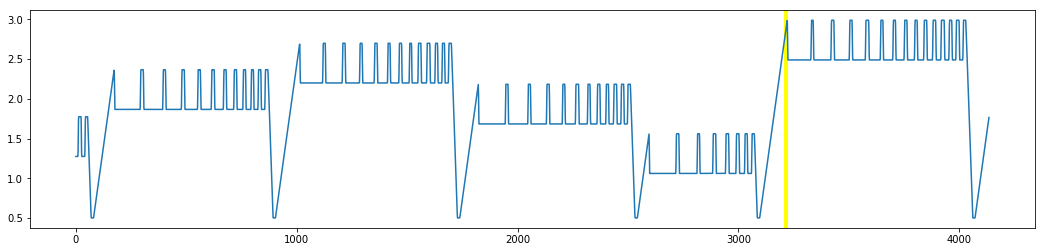

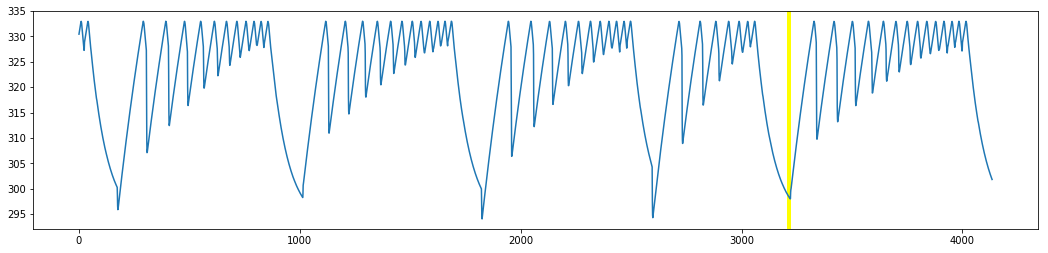

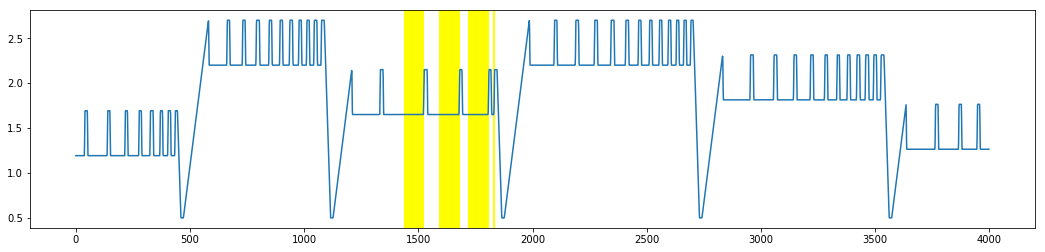

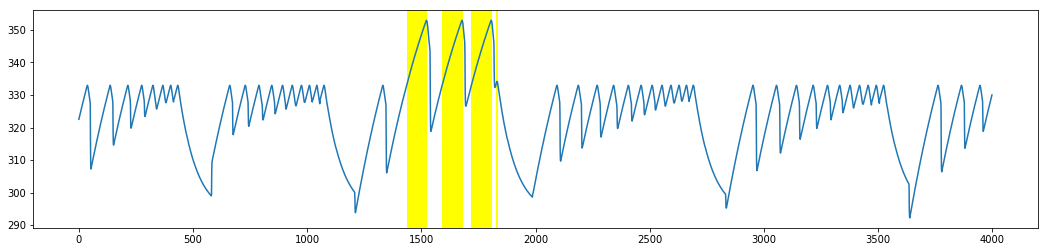

In [57]:
#show_x_y(X_test[6],Y_test[6],n=0)
#show_x_y(X_test[6],Y_test[6],n=1)
show_x_y(X_test[10][6000:],Y_test[10][6000:],n=0)
show_x_y(X_test[10][6000:],Y_test[10][6000:],n=1)
#show_x_y(X_test[25],Y_test[25],n=0)
#show_x_y(X_test[25],Y_test[25],n=1)
show_x_y(X_test[-1][4000:8000],Y_test[-1][4000:8000],n=0)
show_x_y(X_test[-1][4000:8000],Y_test[-1][4000:8000],n=1)
#show_x_y(X_test[-5],Y_test[-5],n=1)


In [60]:
ws = 50
eps = 0.9
step = 20 
Y_pred = predict(hmm, X_test[:24],  win_size= ws, eps = eps, step=step)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [61]:
Y_score, Y_pred_score = score(Y_test[:24], Y_pred, ws = 50)
report = classification_report(np.concatenate(Y_score), np.concatenate(Y_pred_score), target_names=['normal', 'anomal'])
print(report)

              precision    recall  f1-score   support

      normal       1.00      0.99      1.00      4815
      anomal       0.39      0.67      0.49        33

    accuracy                           0.99      4848
   macro avg       0.70      0.83      0.74      4848
weighted avg       0.99      0.99      0.99      4848



In [62]:
ws = 50
eps = 0.9
step = 20 
Y_pred = predict(hmm, X_test[24:],  win_size= ws, eps = eps, step=step)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [63]:
Y_score, Y_pred_score = score(Y_test[24:], Y_pred, ws = 50)
report = classification_report(np.concatenate(Y_score), np.concatenate(Y_pred_score), target_names=['normal', 'anomal'])
print(report)

              precision    recall  f1-score   support

      normal       1.00      0.99      1.00      4735
      anomal       0.74      0.93      0.83       113

    accuracy                           0.99      4848
   macro avg       0.87      0.96      0.91      4848
weighted avg       0.99      0.99      0.99      4848



In [55]:
ws = 50
eps = 0.9
step = 20 
Y_pred = predict(hmm, X_test,  win_size= ws, eps = eps, step=step)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


In [72]:
X_test[1].shape

(10226, 2)

In [56]:
Y_score, Y_pred_score = score(Y_test, Y_pred, ws = 50)
report = classification_report(np.concatenate(Y_score), np.concatenate(Y_pred_score), target_names=['normal', 'anomal'])
print(report)

              precision    recall  f1-score   support

      normal       1.00      0.99      1.00      9550
      anomal       0.70      0.86      0.77       146

    accuracy                           0.99      9696
   macro avg       0.85      0.93      0.88      9696
weighted avg       0.99      0.99      0.99      9696



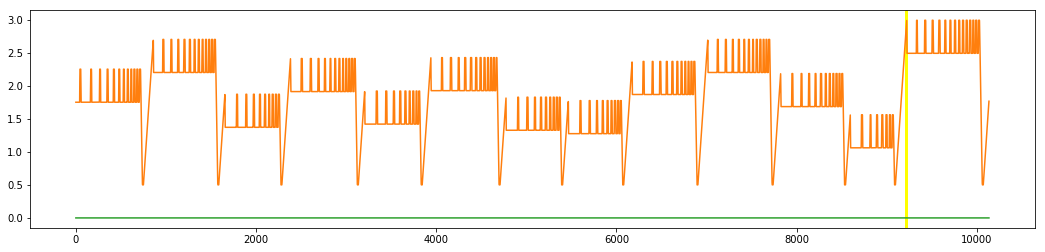

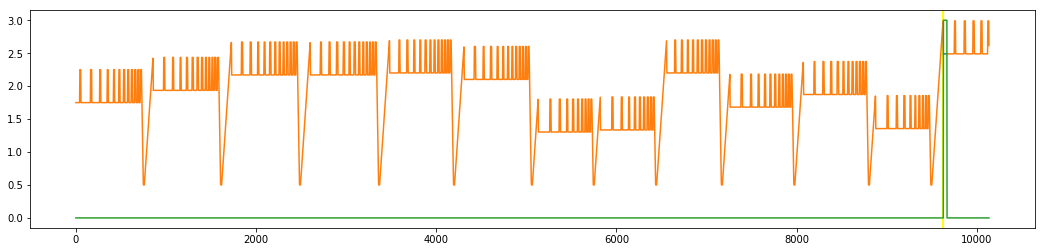

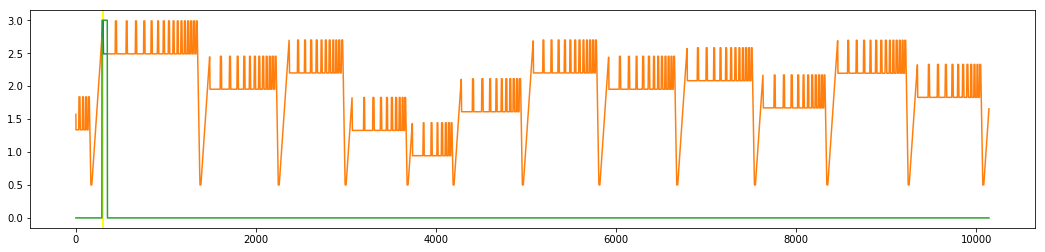

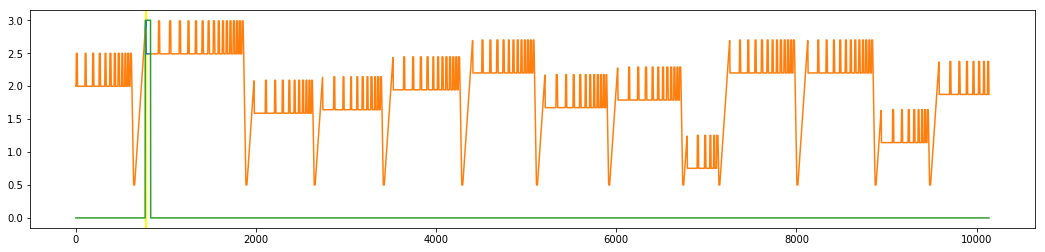

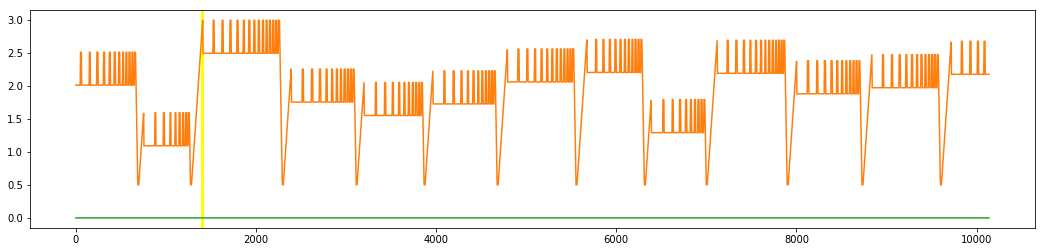

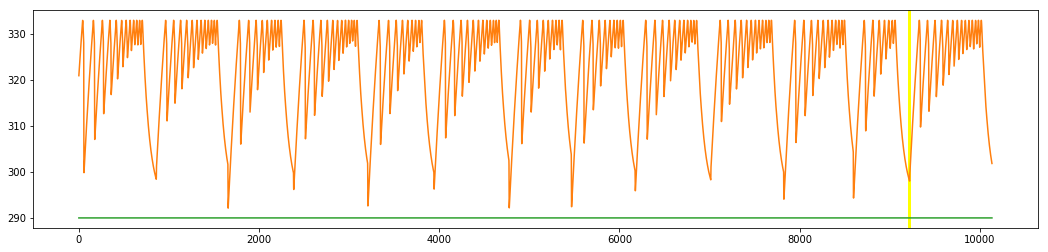

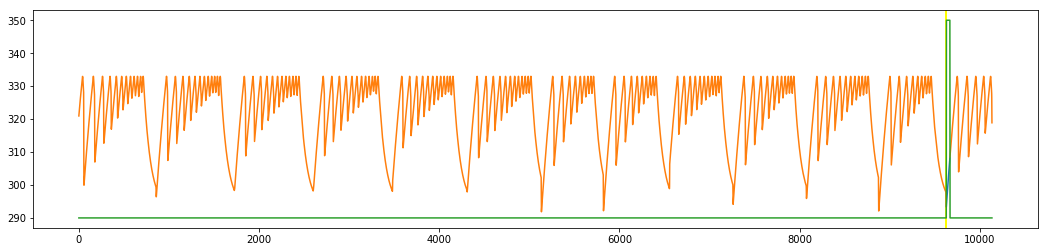

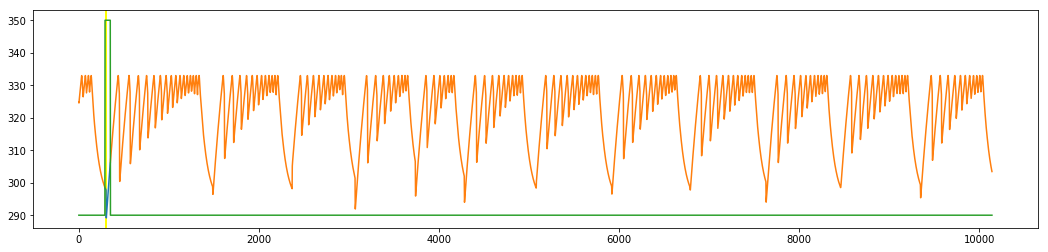

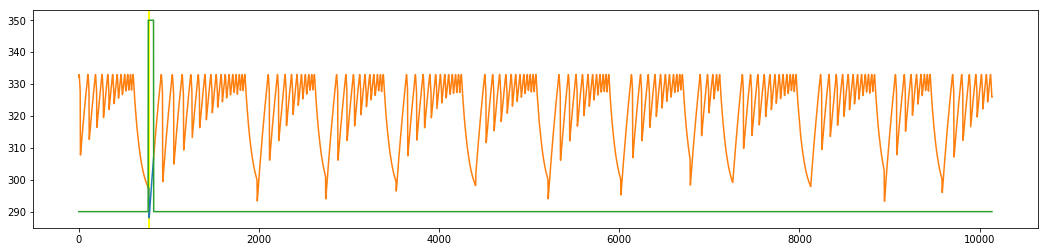

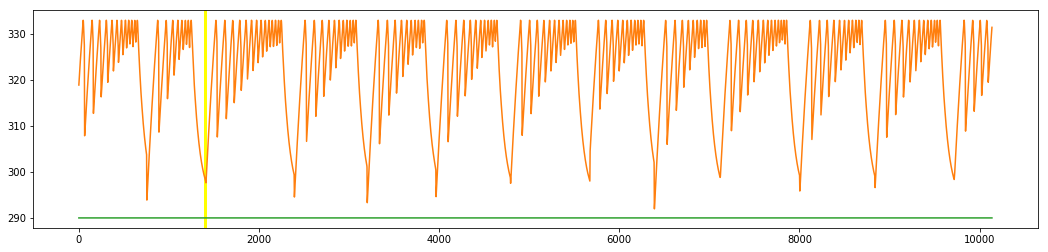

In [58]:
print_result(X_test[10:], Y_test[10:], Y_pred[10:], N=5)
print_result(X_test[10:], Y_test[10:], Y_pred[10:], N=5, dim=1)

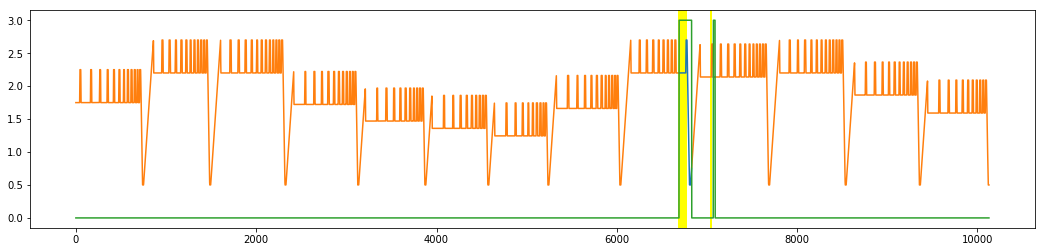

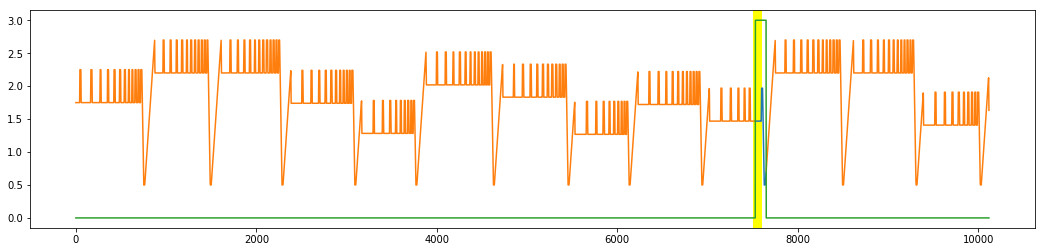

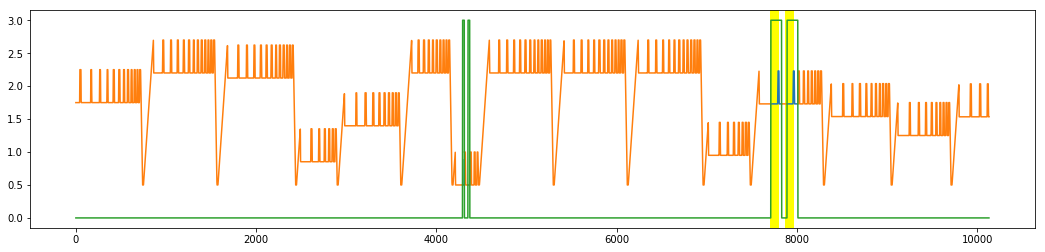

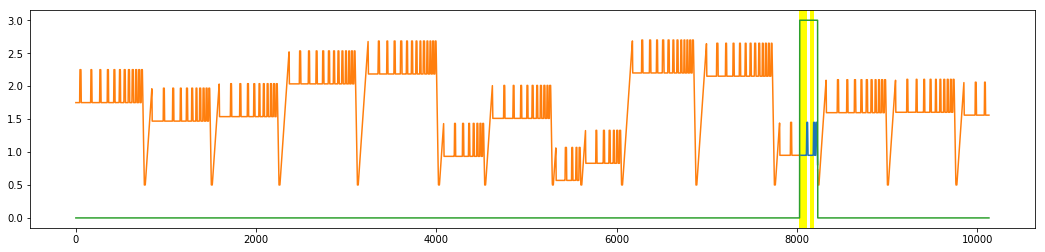

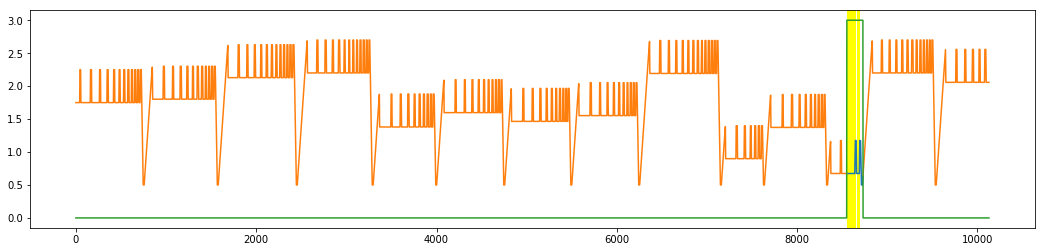

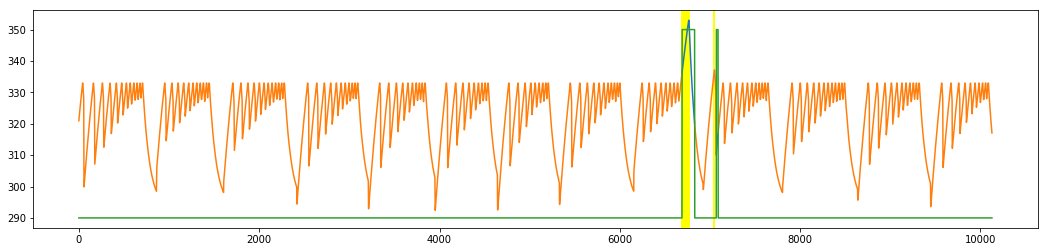

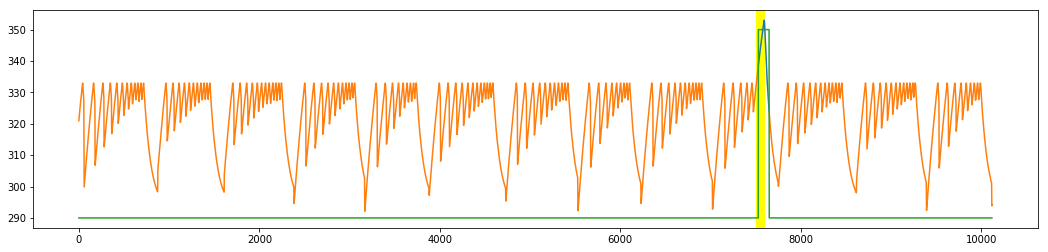

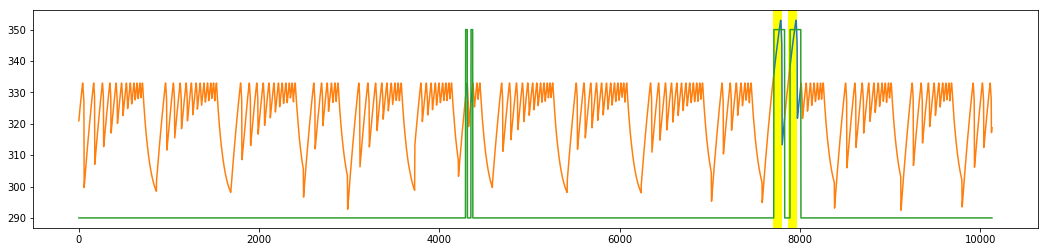

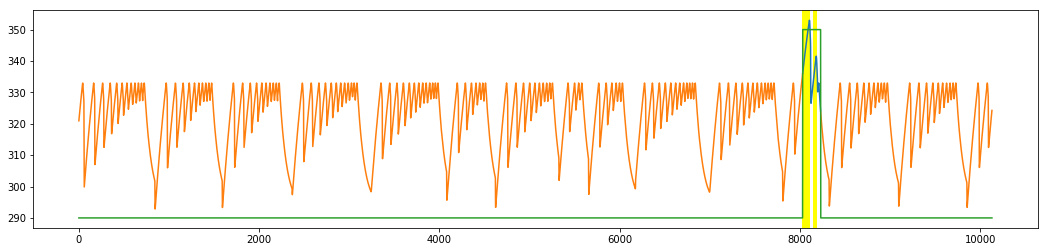

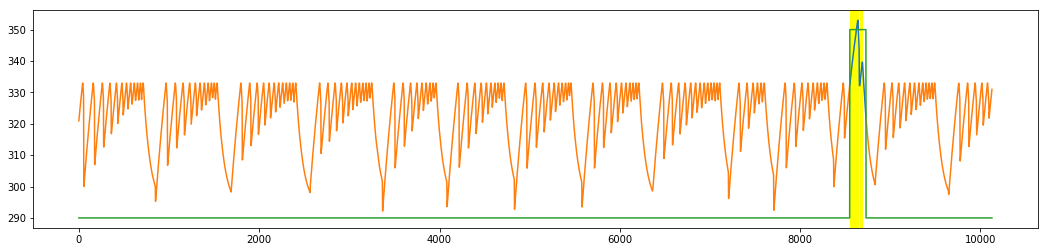

In [59]:
print_result(X_test[30:], Y_test[30:], Y_pred[30:], N=5)
print_result(X_test[30:], Y_test[30:], Y_pred[30:], N=5, dim=1)

In [12]:
def testing(X, Y, model, N=5, ws_s = [20, 45, 60, 80, 100, 120], eps_s = [0.7, 0.8, 0.85, 0.9, 0.95, 1]):
    
    for n in range(N):
        show_x_y(X_test[n],Y_test[n],n=0)
        show_x_y(X_test[n],Y_test[n],n=1)
    
    result_testing = []
    #ws_s = [20, 45, 60, 80, 100, 120, 150, 200]
    #eps_s = [0.15, 0.20, 0.25, 0.3, 0.35, 0.4]
    step_s = [10, 20, 20, 20, 20, 20]
    
    for i in range(len(ws_s)):
        ws = ws_s[i]
        step = step_s[i]
        res_eps = []
        for eps in eps_s:
            Y_pred = predict(model, X, win_size= ws, eps = eps, step =step)
            Y_score, Y_pred_score = score(Y, Y_pred, ws = 50)
            res_eps.append(classification_report(np.concatenate(Y_score), np.concatenate(Y_pred_score), target_names=['normal', 'anomal'], output_dict=True))
        result_testing.append(res_eps)
    return result_testing       

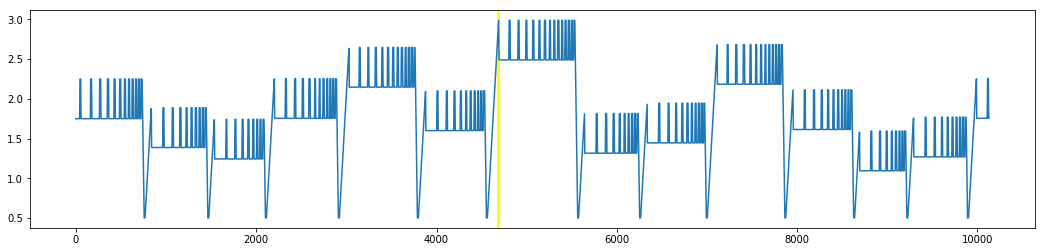

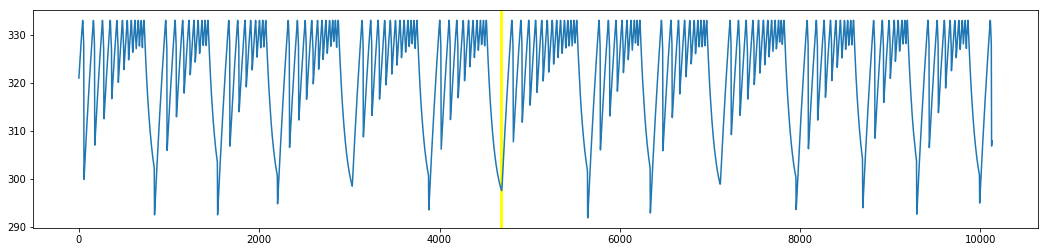

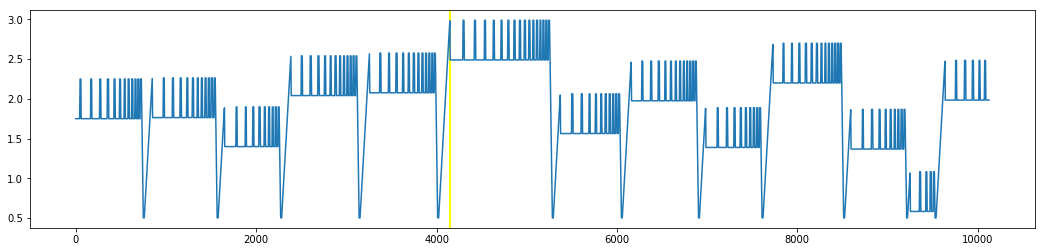

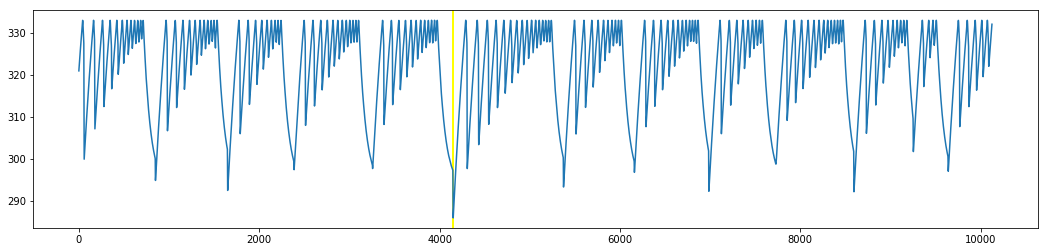

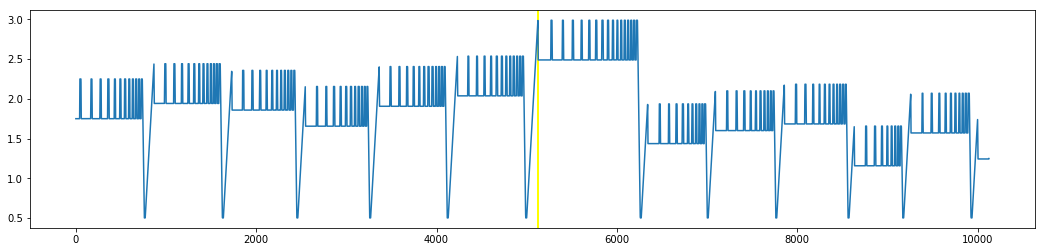

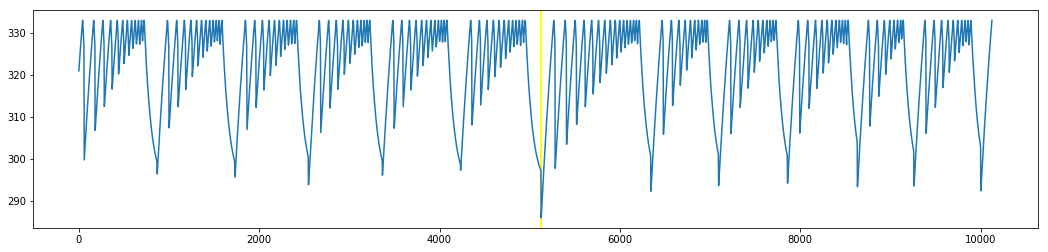

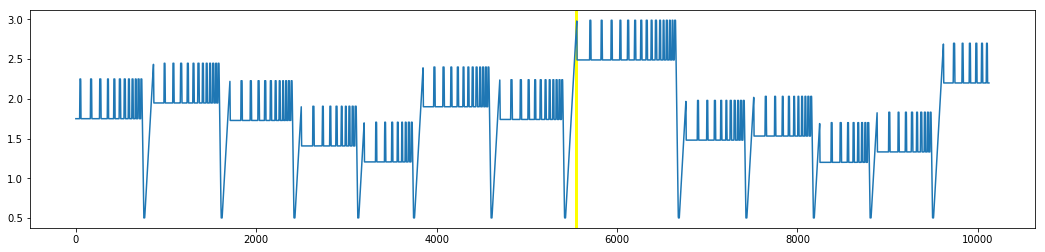

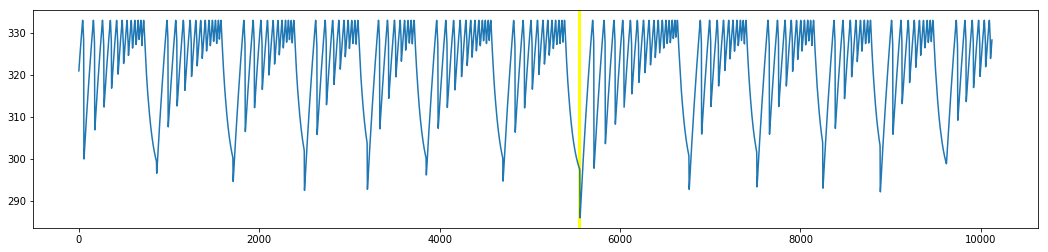

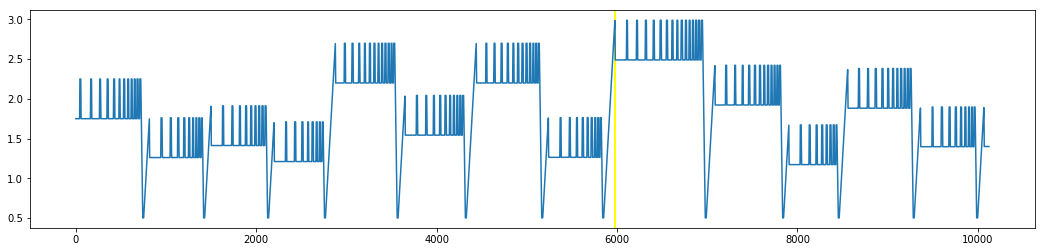

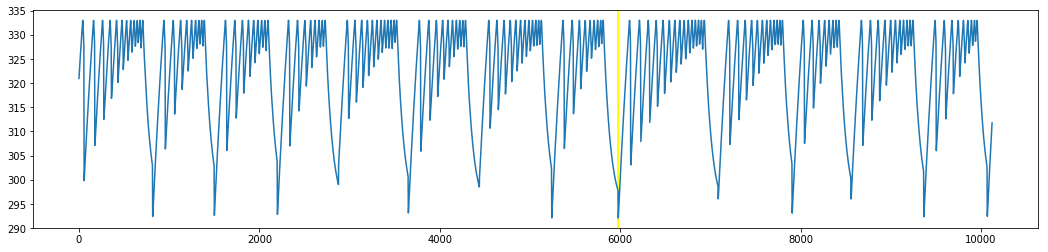

In [13]:
result_anom0 = testing(X_test[:10], Y_test[:10], hmm, N=5)

In [14]:
ws_s = [20, 45, 60, 80, 100, 120]
eps_s = [0.7, 0.8, 0.85, 0.9, 0.95, 1]
step_s = [10, 20, 20, 20, 20, 20]
for i in range(6):
    print('ws',ws_s[i])
    for j in range(6):
        print('eps',eps_s[j], result_anom0[i][j]['anomal'])     
        
       

ws 20
eps 0.7 {'precision': 0.0449438202247191, 'recall': 0.9230769230769231, 'f1-score': 0.0857142857142857, 'support': 13}
eps 0.8 {'precision': 0.04411764705882353, 'recall': 0.9230769230769231, 'f1-score': 0.08421052631578949, 'support': 13}
eps 0.85 {'precision': 0.096, 'recall': 0.9230769230769231, 'f1-score': 0.17391304347826086, 'support': 13}
eps 0.9 {'precision': 0.1348314606741573, 'recall': 0.9230769230769231, 'f1-score': 0.2352941176470588, 'support': 13}
eps 0.95 {'precision': 0.1506849315068493, 'recall': 0.8461538461538461, 'f1-score': 0.2558139534883721, 'support': 13}
eps 1 {'precision': 0.11428571428571428, 'recall': 0.9230769230769231, 'f1-score': 0.20338983050847456, 'support': 13}
ws 45
eps 0.7 {'precision': 0.08695652173913043, 'recall': 0.9230769230769231, 'f1-score': 0.15894039735099338, 'support': 13}
eps 0.8 {'precision': 0.2127659574468085, 'recall': 0.7692307692307693, 'f1-score': 0.33333333333333337, 'support': 13}
eps 0.85 {'precision': 0.2195121951219512

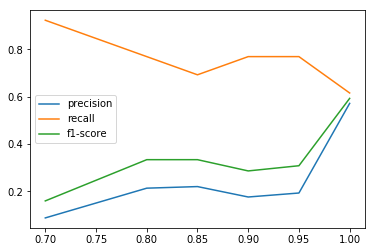

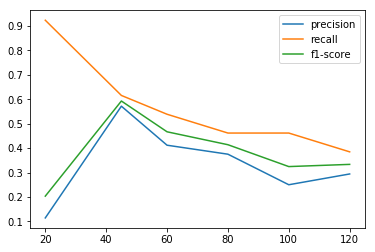

In [15]:
fig, ax = plt.subplots()
axis = eps_s
ax.plot(axis, [x['anomal']['precision'] for x in result_anom0[1]], label = 'precision') 
ax.plot(axis, [x['anomal']['recall'] for x in result_anom0[1]], label = 'recall') 
ax.plot(axis, [x['anomal']['f1-score'] for x in result_anom0[1]], label = 'f1-score')
ax.legend()
plt.show() 
fig, ax = plt.subplots()
axis = ws_s
ax.plot(axis, [x[5]['anomal']['precision'] for x in result_anom0], label = 'precision') 
ax.plot(axis, [x[5]['anomal']['recall'] for x in result_anom0], label = 'recall') 
ax.plot(axis, [x[5]['anomal']['f1-score'] for x in result_anom0], label = 'f1-score')
ax.legend()
plt.show()  

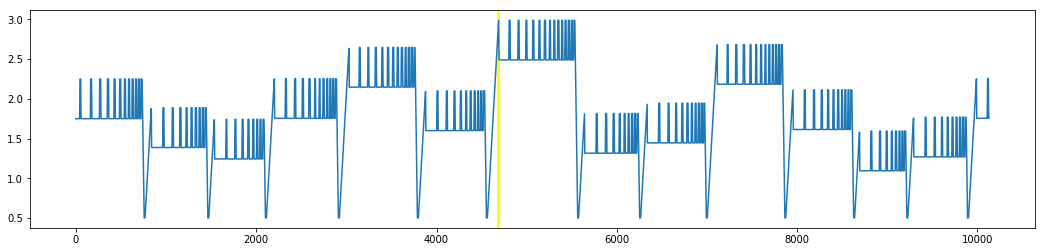

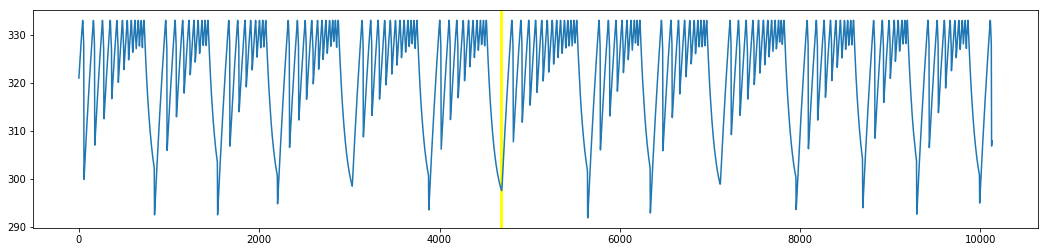

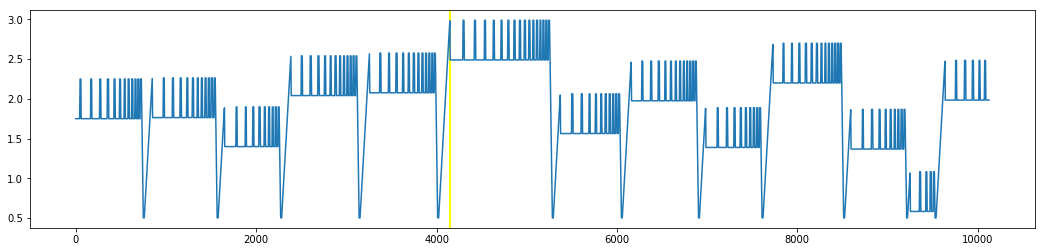

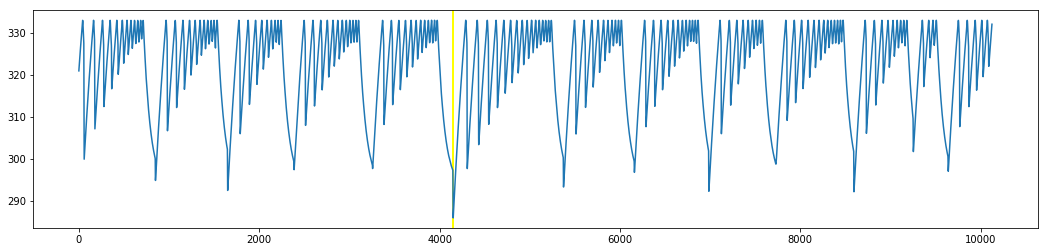

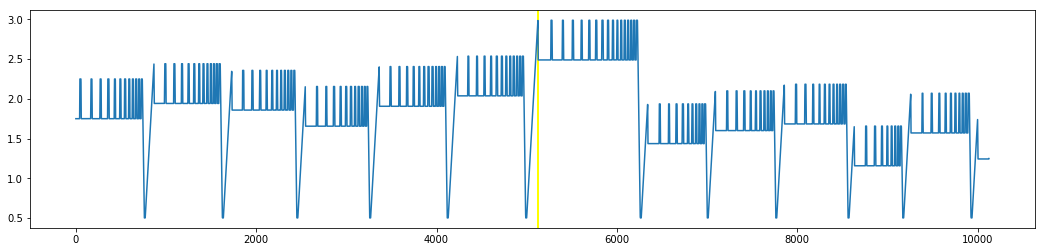

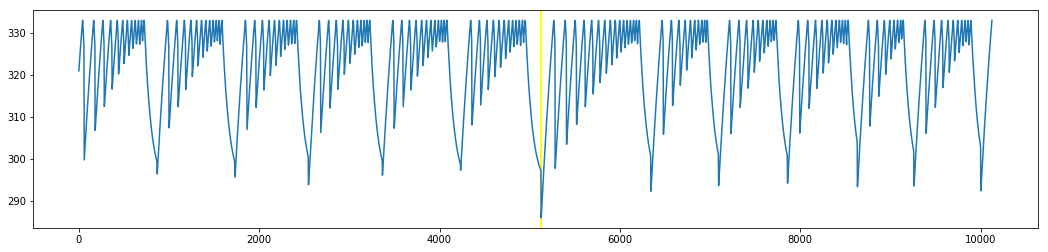

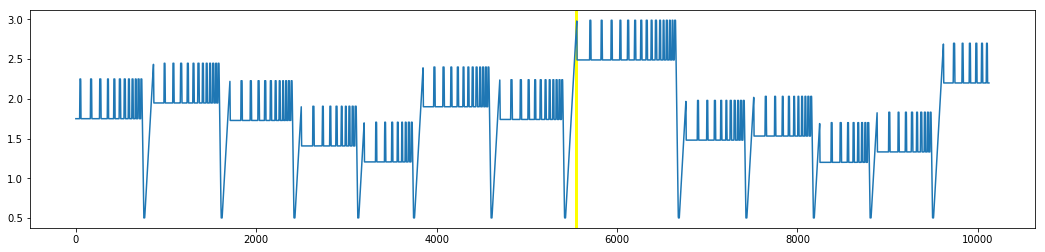

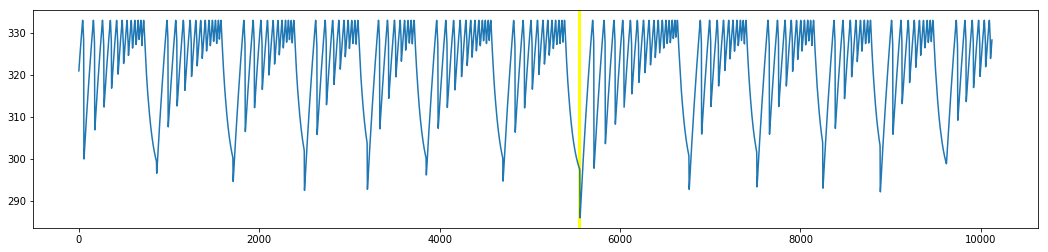

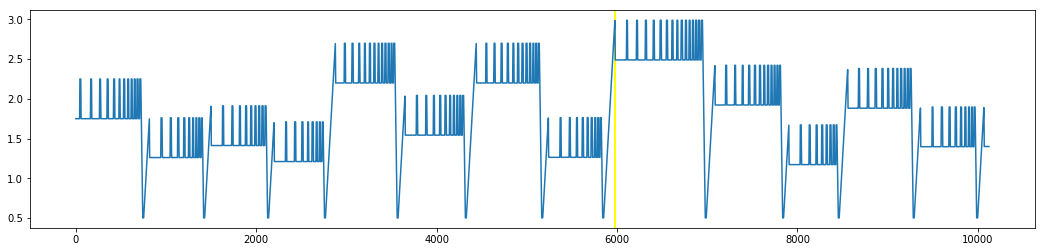

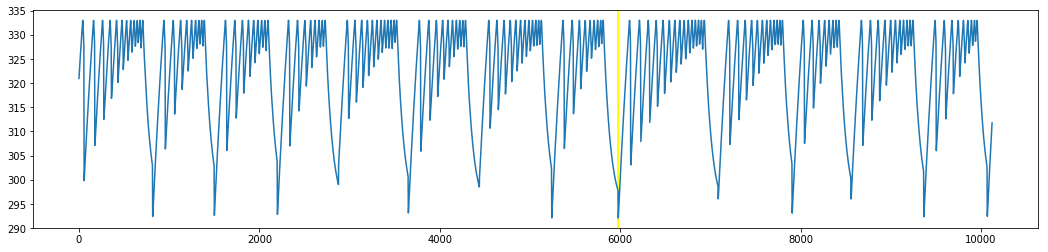

In [16]:
result_anom1 = testing(X_test[30:40], Y_test[30:40], hmm, N=5)

In [17]:
ws_s = [20, 45, 60, 80, 100, 120]
eps_s = [0.7, 0.8, 0.85, 0.9, 0.95, 1]
step_s = [10, 20, 20, 20, 20, 20]
for i in range(6):
    print('ws',ws_s[i])
    for j in range(6):
        print('eps',eps_s[j], result_anom1[i][j]['anomal'])     
        
       

ws 20
eps 0.7 {'precision': 0.2962962962962963, 'recall': 0.9523809523809523, 'f1-score': 0.4519774011299435, 'support': 42}
eps 0.8 {'precision': 0.19230769230769232, 'recall': 0.9523809523809523, 'f1-score': 0.32, 'support': 42}
eps 0.85 {'precision': 0.35714285714285715, 'recall': 0.9523809523809523, 'f1-score': 0.5194805194805194, 'support': 42}
eps 0.9 {'precision': 0.36893203883495146, 'recall': 0.9047619047619048, 'f1-score': 0.5241379310344828, 'support': 42}
eps 0.95 {'precision': 0.28776978417266186, 'recall': 0.9523809523809523, 'f1-score': 0.4419889502762431, 'support': 42}
eps 1 {'precision': 0.2857142857142857, 'recall': 0.9523809523809523, 'f1-score': 0.4395604395604395, 'support': 42}
ws 45
eps 0.7 {'precision': 0.25675675675675674, 'recall': 0.9047619047619048, 'f1-score': 0.4, 'support': 42}
eps 0.8 {'precision': 0.4810126582278481, 'recall': 0.9047619047619048, 'f1-score': 0.628099173553719, 'support': 42}
eps 0.85 {'precision': 0.5, 'recall': 0.9047619047619048, 'f1

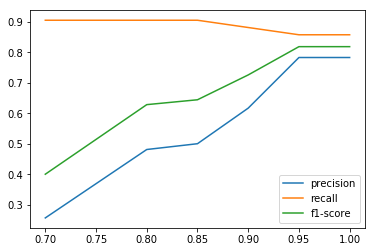

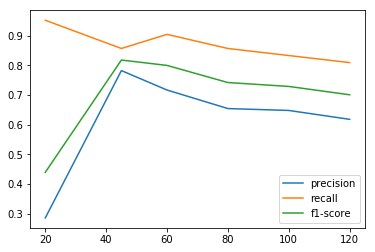

In [18]:
fig, ax = plt.subplots()
axis = eps_s
ax.plot(axis, [x['anomal']['precision'] for x in result_anom1[1]], label = 'precision') 
ax.plot(axis, [x['anomal']['recall'] for x in result_anom1[1]], label = 'recall') 
ax.plot(axis, [x['anomal']['f1-score'] for x in result_anom1[1]], label = 'f1-score')
ax.legend()
plt.show() 
fig, ax = plt.subplots()
axis = ws_s
ax.plot(axis, [x[5]['anomal']['precision'] for x in result_anom1], label = 'precision') 
ax.plot(axis, [x[5]['anomal']['recall'] for x in result_anom1], label = 'recall') 
ax.plot(axis, [x[5]['anomal']['f1-score'] for x in result_anom1], label = 'f1-score')
ax.legend()
plt.show()  